<a href="https://colab.research.google.com/github/MitchellMBurton/Water_Carting_Model/blob/main/Water_Carting_Simulation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Water-tanker carting simulation
Click '*Runtime -> Run all*' to run

This model creates a simulation of a water carting operation in regional Australia and 
provides summary statistics and visualisations which can be used to inform water tanker allocation.

This would usually be accompanied by a seperate report with analysis.

In [1]:
!pip install simpy  

In [2]:
import simpy
import statistics
import random
import matplotlib.pyplot as plt

In [3]:
"""
Mitchell Burton.

WATER CARTING SIMULATION:
This model creates a simulation of a water carting operation in regional Australia and 
provides summary statistics which can be used to inform water tanker allocation.

INSTRUCTIONS - PLEASE READ FOR EFFECTIVE USE

This simulation operates for 1 day per run, the system will not simulate past 
the final simulation time (END OF WORK DAY) and this time must be less than 24 hours.

The user can input how many days they would like to run the model.
Each day is presumed to be a blank state day.
These repeated days are used to create summary statistics and can be extended 
for as many simulations as desired.

###################################
OUTPUTS:
The final average summary statistics will always print to console no matter how
many 'days' the simulation is run for.

###
THESE STATISTICS ARE:

Average total amount of water carted to WTP 
Average total amount of water carted to Reservoir
Average total amount of water carted

Average total cost

Fill point 1 average queue length
fill point 2 average queue length
Fill point 3 average queue length
Fill point 4 average queue length
  
WTP average queue length
Reservoir average queue length

Average round trip time to WTP (minutes)
Average round trip time to Reservoir (minutes)
###

###
The user has 3 further options for outputs, these are chosen at top of inputs:
1. Using 'print_actions' = True OR False: The user can print each action of each 
   tanker in chronological order to the console.
   NOTE! For more than 1 day - this will print every day!

2. Using 'print_stats_and_graphs_each_rep' = True OR False: The user can print
   the summary statistics and graph visualisation for each 'day' the simulation is run.
   NOTE! For more than 1 day - this will print every day!

3. Using 'show_plots_each_rep' = True or False: The user can create and print the 
   graphs associated with each replication. This will only display if 
   'print_stats_and_graphs_each_rep' is also True.
   NOTE! For more than 1 day - this will print every day!

There is not graph for the average summary statistics - The simulation only 
prints the summary statistics.
###

###################################
INPUTS:
'ALL TIMES ARE IN MINUTES'

###
# PRIMARY SETTINGS
Number of 'days' simulated = num_replications

TANKER SIZE AND ROUTE ALLOCATION:
Number of tankers of given size and route is allocated in arrays:
Example: Fill point 1 to WTP = fill_point_1_WTP(2, 1, 1)
This is 2 small, 1 medium and 1 large tanker allocated to Fill point 1 - WTP route

NUMBER OF FILL AND DISCHARGE POINTS:
Fill point 1 fill points = fill_point_1_num_fill
fill point 2 fill points = fill_point_2_num_fill
Fill point 3 fill points = fill_point_3_num_fill
Wodhill fill points = fill_point_4_num_fill

Water Treatment Plant discharge points = WTP_num_discharge
Reservoir discharge points = reservoir_num_discharge

SHIFT SETTINGS:
Start of work day = DAY_SHIFT_START
Start of night shift = NIGHT_SHIFT_START
End of work day = END_OF_WORK_DAY

Maximum shift length = MAX_SHIFT_LENGTH
Actual average shift length = AVERAGE_SHIFT_LENGTH

LUNCH BREAK SETTINGS
Frequency of lunch breaks = LUNCH_BREAK_FREQUENCY
Length of lunch breaks = LUNCH_BREAK_LENGTH
###

###
# SECONDARY SETTINGS

In the secondary settings you can set the specific capacity, cost and category of each tanker.
For fill and discharge stations you can also set the names, travel times between and 
actual kilometre distance.
You can also set the frequency and length of tanker breakdowns and replacements.
###
"""

"\nMitchell Burton.\n\nWATER CARTING SIMULATION:\nThis model creates a simulation of a water carting operation in regional Australia and \nprovides summary statistics which can be used to inform water tanker allocation.\n\nINSTRUCTIONS - PLEASE READ FOR EFFECTIVE USE\n\nThis simulation operates for 1 day per run, the system will not simulate past \nthe final simulation time (END OF WORK DAY) and this time must be less than 24 hours.\n\nThe user can input how many days they would like to run the model.\nEach day is presumed to be a blank state day.\nThese repeated days are used to create summary statistics and can be extended \nfor as many simulations as desired.\n\n###################################\nOUTPUTS:\nThe final average summary statistics will always print to console no matter how\nmany 'days' the simulation is run for.\n\n###\nTHESE STATISTICS ARE:\n\nAverage total amount of water carted to WTP \nAverage total amount of water carted to Reservoir\nAverage total amount of water

WATER CARTING OPERATION
***** REP 1 of 1 *****

WATER TANKER RESULTS AFTER 900 minutes

Kilo liters of water carted to WTP: 559.06
Kilo liters of water carted to Reservoir: 542.95
Total kilo liters of water carted: 1102.01

Total cost: $33514.88

Average queue length - Fill point 1: 0.56
Average queue length - Fill point 2: 0.51
Average queue length - Fill point 3: 0.44
Average queue length - Fill point 4: 0.43

Average queue length - WTP: 0.57
Average queue length - Reservoir: 0.03

Average round trip time to WTP (minutes): 219.13
Average round-trip time to Reservoir (minutes): 231.57


#################################################

SUMMARY STATISTICS FOR 1 REPLICATION/S: 
Average total amount of water carted to WTP is: 559.06kl
Average total amount of water carted to Reservoir is: 542.95kl
Average total amount of water carted is: 1102.01kl

Average total cost is: $33514.88

Fill point 1 average queue length is: 0.56
fill point 2 average queue length is: 0.51
Fill point 3 average 

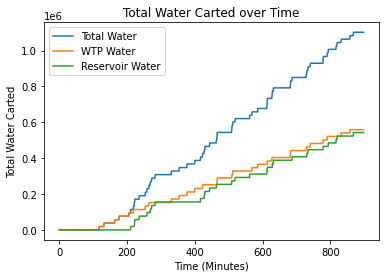

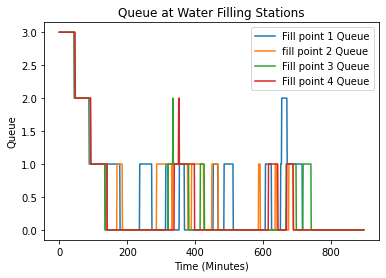

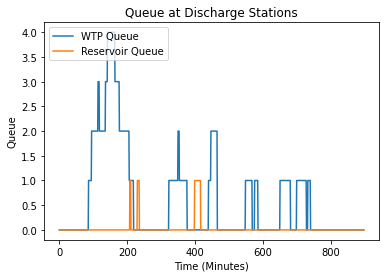

In [4]:
### PRIMARY SETTINGS
## OUTPUT OPTIONS
print_actions = False # WARNING - Set False for many replications (Output is excessive)
print_stats_and_graphs_each_rep = True # WARNING - Set False for many replications (Output is excessive)
show_plots_each_rep = True # WARNING - set False for many replications (Output is excessive)

## MAJOR SETTINGS FOR EACH RUN
## Number of days (repetitions) to simulate
num_replications = 1

## Tanker routes
# (Small, Medium, Large)
# Fill point to WTP
fill_point_1_WTP = (0, 0, 2)
helent_st_WTP = (0, 0, 2)
fill_point_3_WTP = (0, 0, 2)
fill_point_4_WTP = (0, 0, 2)
# Fill point to Resevoir
fill_point_1_reservoir = (0, 0, 2)
helent_st_reservoir = (0, 0, 2)
fill_point_3_reservoir = (0, 0, 2)
fill_point_4_reservoir = (0, 0, 2)

# Number of fill points at each station
fill_point_1_num_fill = 1
fill_point_2_num_fill = 1
fill_point_3_num_fill = 1
fill_point_4_num_fill = 1

# Number of discharge points at each station
WTP_num_discharge = 2
reservoir_num_discharge = 4

# USE 24 hour time to set shift start, night time start and work day end times
DAY_SHIFT_START = 7*60 # 7AM 
NIGHT_SHIFT_START = 19*60 # 7PM 
END_OF_WORK_DAY = 22*60 # 10pm

# Shift settings
MAX_SHIFT_LENGTH = 10*60 # 10 hours
AVERAGE_SHIFT_LENGTH = 8*60

# Lunch break timing
LUNCH_BREAK_FREQUENCY = 4*60 # Every 4 hours
LUNCH_BREAK_LENGTH = 30

### SECONDARY SETTINGS: 
# Fill and discharge rate
TANKER_FILL_DISCHARGE_RATE = 10 # L/s

## Tanker types, capacities and cost
tanker_type = ["Small", "Medium", "Large"]
tanker_capacities = [8000, 12000, 20000] # Liters
tanker_cost_per_hour_day = [80, 120, 165] # Dollars
tanker_cost_per_hour_night = [100, 140, 185] # Dollars

## Tanker route settings
# Fill point and discharge point names
fill_point_names = ("Fill point 1", "fill point 2", "Fill point 3", "Fill point 4")
discharge_point_names = ("WTP", "Reservoir")

# Travel times to/from
# (Fill point 1, fill point 2, Fill point 3, Fill point 4)
fill_point_to_WTP = (24.9, 40.5, 41, 47.8) 
fill_point_to_reservoir = (27.7, 36.9, 40.5, 44.2)
WTP_to_fill_point = (21.8, 35.5, 35.9, 41.9)
reservoir_to_fill_point = (24.3, 32.3, 35.4, 38.7)

# Distance km 
# (Fill point 1, fill point 2, Fill point 3, Fill point 4)
fill_point_to_WTP_dist = (29, 47.3, 47.8, 55.8)
fill_point_to_reservoir_dist = (32.4, 43.1, 47.2, 51.6)

# Breakdown timing
BREAK_DOWN_LENGTH = 120
BREAK_DOWN_FREQUENCY = 1440*5 # Some estimation as wear and tear does not accrue

###############################################################################
## PREPARING INPUTS FOR SIMULATION: 
SIM_END = END_OF_WORK_DAY - DAY_SHIFT_START 
TIME_UNTIL_NIGHT_STARTS = NIGHT_SHIFT_START - DAY_SHIFT_START 

tankers_from_to_number_size = [[fill_point_1_WTP, helent_st_WTP, fill_point_3_WTP, fill_point_4_WTP], [fill_point_1_reservoir, helent_st_reservoir, fill_point_3_reservoir, fill_point_4_reservoir]]

fill_point_to_discharge_point = [fill_point_to_WTP, fill_point_to_reservoir] 
discharge_point_to_fill_point = [WTP_to_fill_point, reservoir_to_fill_point] 

route_distances = [fill_point_to_WTP_dist, fill_point_to_reservoir_dist]
###############################################################################
###############################################################################
class Water_Carting_Operation(object):
  def __init__(self, env, fill_points, discharge_points):
    # Initialise values
    self.env = env

    self.total_water_carted_to_WTP = 0
    self.total_water_carted_to_reservoir = 0
    self.total_water_carted = 0

    # Cost
    self.total_cost = 0
    self.total_day_cost = 0
    self.total_night_cost = 0

    # Hours operating
    self.tanker_cycles_WTP = []
    self.tanker_cycles_reservoir = []
    self.water_over_time = []
    self.water_over_time_WTP = []
    self.water_over_time_reservoir = []
    self.time = []

    # Each tanker
    self.all_tankers = []

    # Load resources
    self.fill_points = fill_points
    self.discharge_points = discharge_points

    # Queuing stats fill points
    self.fill_point_1_queue = []
    self.fill_point_2_queue = []
    self.fill_point_3_queue = []
    self.fill_point_4_queue = []
    # Queuing stats discharge points
    self.WTP_queue = []
    self.reservoir_queue = []

    # Trip times
    self.G_trip_times_WTP = []
    self.G_trip_times_reservoir = []

    # Start stats
    self.env.process(self.statistics())

  # Create statistics process
  def statistics(self):
    while True:
      yield self.env.timeout(1)
      # Get fill point queue statistics
      self.fill_point_1_queue.append(len(self.fill_points[0].queue))
      self.fill_point_2_queue.append(len(self.fill_points[1].queue))
      self.fill_point_3_queue.append(len(self.fill_points[2].queue))
      self.fill_point_4_queue.append(len(self.fill_points[3].queue))
      # Get discharge point queue statistics
      self.WTP_queue.append(len(self.discharge_points[0].queue))
      self.reservoir_queue.append(len(self.discharge_points[1].queue))
      # Get Total water carted statistics
      self.water_over_time.append(self.total_water_carted)
      self.water_over_time_WTP.append(self.total_water_carted_to_WTP)
      self.water_over_time_reservoir.append(self.total_water_carted_to_reservoir)


class Water_Tanker(object):
  """ A water tanker that carts water from a fill up point
  to a discharge point and repeats.
  The driver has a lunch break every 4 hours of operating.
  If it breaks down it is replaced in 2 hours by another tanker of same type.

  """
  def __init__(self, env, name, tanker_capacity, fill_point, discharge_point, water_carting_operation, cost_per_hour_day, cost_per_hour_night, travel_time_to, travel_time_back, travel_dist_km, shift_number, print_actions = False):
    # Initialise
    self.env = env
    self.name = name
    self.fill_point = fill_point
    self.discharge_point = discharge_point
    self.tanker_capacity = tanker_capacity
    self.travel_time_to = travel_time_to
    self.travel_time_back = travel_time_back
    self.cost_per_hour_day = cost_per_hour_day
    self.cost_per_hour_night = cost_per_hour_night
    self.route_distance = travel_dist_km 
    self.shift_number = shift_number
    self.fuel_tank = 400*random.uniform(0.5,1)
    self.fuel_consumption = 33/100 # L/km
    self.water_carting_operation = water_carting_operation
    self.print_actions = print_actions

    # Initial States
    self.broken = False
    self.on_lunch_break = False
    self.refueling = False
    self.change_shift = False
    self.retire_tanker = False

    # Initial statistics
    self.total_water_carted = 0
    self.water_carted_to_WTP = 0
    self.water_carted_to_reservoir = 0
    self.hours_operating = 0                                
    self.trip_times = []

    # For calculations
    self.add_time = 0

    # Start *carting*, *breakdown*, *lunch_break*, *shift change* and *statistics* processes
    self.process = self.env.process(self.water_carting(self.fill_point, self.discharge_point))
    self.env.process(self.break_down())
    self.env.process(self.lunch_break())
    self.env.process(self.shift_change())

  # Overall water carting process for each tanker
  def water_carting(self, fill_point, discharge_point):
    """ Fill up water tank, go to location, discharge tank, return to fill 
    up point. REPEAT

    While operating, the tanker may break down, the driver will take lunch 
    breaks and the tanker may need refueling.

    """
    while not self.retire_tanker:
      START = self.env.now
      # Calculate travel times
      self.timing_calculator()
      
      # Check for shift change or final run
      yield self.env.process(self.shift_change_process())
      self.final_run_process()
      if self.retire_tanker:
        break      

      # FILL UP
      yield self.env.process(self.fill_up_process())
      # Get timing and cost
      AFTER_FILL_UP = self.env.now
      self.add_time = AFTER_FILL_UP - START
      self.calc_cost()

      # DRIVE TO DISCHARGE LOCATION
      yield self.env.process(self.drive_to_process())
      # Get timing and cost       
      AFTER_DRIVE_TO = self.env.now
      self.add_time = AFTER_DRIVE_TO - AFTER_FILL_UP
      self.calc_cost()

      # DISCHARGE
      yield self.env.process(self.discharge_process())
      # Get timing and cost    
      AFTER_DISCHARGE = self.env.now
      self.add_time = AFTER_DISCHARGE - AFTER_DRIVE_TO
      self.calc_cost()

      # DRIVE BACK TO FILL UP STATION
      yield self.env.process(self.drive_back_process())
      # Get timing and cost    
      AFTER_DRIVE_BACK = self.env.now
      self.add_time = AFTER_DRIVE_BACK - AFTER_DISCHARGE
      self.calc_cost()

      # Calculate trip time
      END = self.env.now
      trip_time = END-START

      # Track each trip time
      self.calc_trip_time(trip_time)
  
########################## Define major processes #############################

  # Trip time calculator
  def timing_calculator(self):
    # fill
    self.tanker_fill = (self.tanker_capacity*random.triangular(0.9,1,1)) 
    tanker_fill_rate = (TANKER_FILL_DISCHARGE_RATE*60)*random.triangular(0.85,1,0.85)
    self.fill_time_yield = (self.tanker_fill/tanker_fill_rate)
    # drive to
    self.drive_to_yield = self.travel_time_to*random.triangular(1,1.15,1)
    # discharge
    tanker_discharge_rate = (TANKER_FILL_DISCHARGE_RATE*60)*random.triangular(0.85,1,0.85)
    self.discharge_yield = (self.tanker_fill/tanker_discharge_rate)  
    # drive back
    self.drive_back_yield = self.travel_time_back*random.triangular(1,1.15,1)
    # Round trip calculation
    self.round_trip = self.fill_time_yield + self.drive_to_yield + self.discharge_yield + self.drive_back_yield
    # Shift threshold calculation
    self.shift_limit = self.env.now + self.round_trip + 30
  
  # Fill up process 
  def fill_up_process(self):
    # print(len(self.fill_point.queue))
    with self.fill_point.request() as req:
      yield req
      # Add time for connecting and disconnecting
      if self.env.now < 12*60:
        yield self.env.timeout(10)
      else:
        yield self.env.timeout(12)
      if self.print_actions:
        print("%s Fill tank at %d" % (self.name, self.env.now))
      yield self.env.timeout(self.fill_time_yield)

    # Check for lunch and breakdown processes
    yield self.env.process(self.lunch_break_process())
    yield self.env.process(self.break_down_process())

  # Drive to discharge location process
  def drive_to_process(self):
    if self.print_actions:
      print("%s Drive to at %d" % (self.name, self.env.now))
    yield self.env.timeout(self.drive_to_yield)
    self.fuel_tank -= self.fuel_consumption  * self.route_distance # Fuel consumption 33/100 * route distance

    # Check for lunch, breakdown and refuel processes
    yield self.env.process(self.lunch_break_process())
    yield self.env.process(self.break_down_process())
    yield self.env.process(self.re_fuel())
    yield self.env.process(self.lunch_break_process())
    yield self.env.process(self.break_down_process())

  # Discharge water process
  def discharge_process(self):
    with self.discharge_point.request() as req:   
      yield req

      # Add time for connecting and disconnecting
      if self.env.now < TIME_UNTIL_NIGHT_STARTS:
        yield self.env.timeout(10)
      else:
        yield self.env.timeout(12)
      # print aaction
      if self.print_actions:
        print("%s Discharge tank at %d" % (self.name, self.env.now))
      # yield for time calculated
      yield self.env.timeout(self.discharge_yield)
      # Capture total water carted      
      self.total_water_carted += self.tanker_fill
      self.water_carting_operation.total_water_carted += self.tanker_fill
      # Capture how much water was carted to each discharge point
      if discharge_point_names[0] in self.name:
        self.water_carted_to_WTP += self.tanker_fill
        self.water_carting_operation.total_water_carted_to_WTP += self.tanker_fill
      else:
        self.water_carted_to_reservoir += self.tanker_fill
        self.water_carting_operation.total_water_carted_to_reservoir += self.tanker_fill     

    # Check for lunch and breakdown processes
    yield self.env.process(self.lunch_break_process())
    yield self.env.process(self.break_down_process())

  # Drive back to fill up location process
  def drive_back_process(self):
    if self.print_actions:
      print("%s Drive back at %d" % (self.name, self.env.now))
    yield self.env.timeout(self.drive_back_yield)
    self.fuel_tank -= self.fuel_consumption  * self.route_distance

    # Check for final run, lunch, breakdown and refuel processes
    self.final_run_process()   
    yield self.env.process(self.lunch_break_process())
    yield self.env.process(self.break_down_process())
    yield self.env.process(self.re_fuel())
    yield self.env.process(self.lunch_break_process())
    yield self.env.process(self.break_down_process())
    yield self.env.process(self.shift_change_process())
    self.final_run_process()

################### Define event creators and processes #######################

  # Break down event creator
  def break_down(self): 
    """ Tanker breaks down every now and then"""
    while True:
      yield self.env.timeout(random.expovariate(1/(BREAK_DOWN_FREQUENCY*5)))
      self.broken = True

  # Break down process
  def break_down_process(self):
    if self.broken:
      if self.print_actions:
        print("%s Breakdown at %d" % (self.name, self.env.now))
      yield self.env.timeout(BREAK_DOWN_LENGTH)
      if self.print_actions:
        print("%s Replaced at %d" % (self.name, self.env.now))
      # Replace tanker
      self.retire_tanker = True
      self.water_carting_operation.all_tankers.append(Water_Tanker(self.env, self.name, self.tanker_capacity, self.fill_point, self.discharge_point, self.water_carting_operation, self.cost_per_hour_day, self.cost_per_hour_night, self.travel_time_to, self.travel_time_back, self.route_distance, self.shift_number, self.print_actions))

  # Lunch break event creator
  def lunch_break(self):
    """ Driver has lunch break every 4 hours += 15 mins """
    while True:
      yield self.env.timeout(LUNCH_BREAK_FREQUENCY)
      self.on_lunch_break = True

  # Lunch break process
  def lunch_break_process(self):
    if self.on_lunch_break:
      if self.print_actions:
        print("%s Start lunch break at %d" % (self.name, self.env.now))
      yield self.env.timeout(LUNCH_BREAK_LENGTH)
      self.on_lunch_break = False
      if self.print_actions:
        print("%s End lunch break at %d" % (self.name, self.env.now))
      if self.env.now < TIME_UNTIL_NIGHT_STARTS:
        self.water_carting_operation.total_day_cost -= (LUNCH_BREAK_LENGTH/60)*self.cost_per_hour_day
      else:
        self.water_carting_operation.total_night_cost -= (LUNCH_BREAK_LENGTH/60)*self.cost_per_hour_night 

  # Re-fuel process
  def re_fuel(self):
    if self.fuel_tank < 30: # 30L is arbitrary choice
      if self.print_actions:
        print("%s FUEL TANK LOW Start refueling at %d" % (self.name, self.env.now))
      yield self.env.timeout(30)
      self.fuel_tank = 400 # Fill up the fuel tank
      if self.print_actions:
        print("%s End refueling at %d" % (self.name, self.env.now))

  # Shift change event creator
  def shift_change(self):
    """ Driver has shift change every 10 hours + upto 30 mins """
    while True:
      yield self.env.timeout(AVERAGE_SHIFT_LENGTH)
      self.change_shift = True

  # Shift change process
  def shift_change_process(self):
    if self.change_shift or self.shift_limit > (MAX_SHIFT_LENGTH*self.shift_number + 30):
      if self.print_actions:
        print("%s Shift over - Change driver and tanker at %d" % (self.name, self.env.now))
      yield self.env.timeout(15)
      self.change_shift = False
      if self.print_actions:
        print("%s Shift change complete at %d" % (self.name, self.env.now))
      # Create new water tanker
      self.shift_number += 1
      new_name = self.name 
      new_shift = self.shift_number
      self.retire_tanker = True
      self.water_carting_operation.all_tankers.append(Water_Tanker(self.env, new_name, self.tanker_capacity, self.fill_point, self.discharge_point, self.water_carting_operation, self.cost_per_hour_day, self.cost_per_hour_night, self.travel_time_to, self.travel_time_back, self.route_distance, new_shift, self.print_actions))

  # Determine if doing final run
  def final_run_process(self):
    if self.shift_limit > SIM_END or self.shift_limit > 24*60:
      self.retire_tanker = True
      if self.print_actions:
        print("%s STOP FOR THE DAY at %d" % (self.name, self.env.now))
  
######################## Define calculation methods ############################
  
  # Calculate cost at each stage
  def calc_cost(self):
    if self.env.now < TIME_UNTIL_NIGHT_STARTS:
      self.water_carting_operation.total_day_cost += (self.add_time/60)*self.cost_per_hour_day
    else:
      self.water_carting_operation.total_night_cost += (self.add_time/60)*self.cost_per_hour_night
  
  # Calculate each trip time
  def calc_trip_time(self, trip_time):
    if discharge_point_names[0] in self.name:
      self.water_carting_operation.G_trip_times_WTP.append(trip_time)
    else:
      self.water_carting_operation.G_trip_times_reservoir.append(trip_time)

###############################################################################
###############################################################################
def simulation_run(print_stats_and_graphs_each_rep, show_plots_each_rep, fill_point_names, discharge_point_names, tanker_type, tanker_capacities, tanker_cost_per_hour_day, tanker_cost_per_hour_night, fill_point_to_discharge_point, discharge_point_to_fill_point, route_distances): 
  # ### Setup and start simulation
  # print("WATER CARTING OPERATION")
  
  ### Create environment and start setup process
  env = simpy.Environment()

  ### Create resources
  # Fill points
  fill_points = []
  fill_point_1 = simpy.Resource(env, fill_point_1_num_fill)
  fill_point_2 = simpy.Resource(env, fill_point_2_num_fill)
  fill_point_3 = simpy.Resource(env, fill_point_3_num_fill)
  fill_point_4 = simpy.Resource(env, fill_point_4_num_fill)
  fill_points.extend([fill_point_1, fill_point_2, fill_point_3, fill_point_4])

  # Discharge points
  discharge_points = []
  WTP = simpy.Resource(env, WTP_num_discharge)
  reservoir = simpy.Resource(env, reservoir_num_discharge)
  discharge_points.extend([WTP, reservoir])

  # Create water carting operation
  water_carting_operation = Water_Carting_Operation(env, fill_points, discharge_points)

  # Create all tankers 
  all_tankers = []
  for disch in range(len(discharge_points)):
    for fill in range(len(fill_points)):
      for j in range(len(tanker_capacities)):
        all_tankers.extend([Water_Tanker(env, fill_point_names[fill] + " - " + discharge_point_names[disch] + " %d - %s: " % (i, tanker_type[j]), tanker_capacities[j], fill_points[fill], discharge_points[disch], water_carting_operation, tanker_cost_per_hour_day[j], tanker_cost_per_hour_night[j], fill_point_to_discharge_point[disch][fill], discharge_point_to_fill_point[disch][fill], route_distances[disch][fill],  shift_number = 1, print_actions = print_actions) for i in range(tankers_from_to_number_size[disch][fill][j])])
      
  ### Execute
  env.run(until = SIM_END)
  #################################################
  if print_stats_and_graphs_each_rep:
    # Analysis
    print ("\n" + 'WATER TANKER RESULTS AFTER %d minutes' % SIM_END + '\n')
    print('Kilo liters of water carted to WTP: %.2f' % (water_carting_operation.total_water_carted_to_WTP/1000))
    print('Kilo liters of water carted to Reservoir: %.2f' % (water_carting_operation.total_water_carted_to_reservoir/1000))
    print("Total kilo liters of water carted: %.2f" % (water_carting_operation.total_water_carted_to_WTP/1000 + water_carting_operation.total_water_carted_to_reservoir/1000) +"\n")

    print('Total cost: $%.2f' % (water_carting_operation.total_day_cost+water_carting_operation.total_night_cost) + "\n")

    print("Average queue length - Fill point 1: %.2f" % statistics.mean(water_carting_operation.fill_point_1_queue))
    print("Average queue length - Fill point 2: %.2f" % statistics.mean(water_carting_operation.fill_point_2_queue))
    print("Average queue length - Fill point 3: %.2f" % statistics.mean(water_carting_operation.fill_point_3_queue))
    print("Average queue length - Fill point 4: %.2f" % statistics.mean(water_carting_operation.fill_point_4_queue) + "\n")

    print("Average queue length - WTP: %.2f" % statistics.mean(water_carting_operation.WTP_queue))
    print("Average queue length - Reservoir: %.2f" % statistics.mean(water_carting_operation.reservoir_queue) + "\n")
    
    # Adding trip times gets a no data error when no tankers going to one of discharge points
    try:
      print("Average round trip time to WTP (minutes): %.2f" % statistics.mean(water_carting_operation.G_trip_times_WTP))
    except:
      print("Average round trip time to WTP (minutes): %.2f" % 0)
    try:  
      print("Average round-trip time to Reservoir (minutes): %.2f" % statistics.mean(water_carting_operation.G_trip_times_reservoir))
    except:
      print("Average round- trip time to Reservoir (minutes): %.2f" % 0)
    
    print("\n")

    ## Create plots
    # Plot of water carted over time
    if show_plots_each_rep:
      fig1, water = plt.subplots()
      water.plot(water_carting_operation.water_over_time, label = "Total Water")
      water.plot(water_carting_operation.water_over_time_WTP, label = "WTP Water")
      water.plot(water_carting_operation.water_over_time_reservoir, label = "Reservoir Water")
      water.legend(loc = "upper left")
      water.set_title("Total Water Carted over Time")
      water.set_xlabel('Time (Minutes)')
      water.set_ylabel("Total Water Carted")
      fig1.show()
      # Plot of fill point queue length
      fig2, fillpoint_queue = plt.subplots()
      fillpoint_queue.plot(water_carting_operation.fill_point_1_queue, label = "Fill point 1 Queue")
      fillpoint_queue.plot(water_carting_operation.fill_point_2_queue, label = "fill point 2 Queue")
      fillpoint_queue.plot(water_carting_operation.fill_point_3_queue, label = "Fill point 3 Queue")
      fillpoint_queue.plot(water_carting_operation.fill_point_4_queue, label = "Fill point 4 Queue")
      fillpoint_queue.legend(loc = "upper right")
      fillpoint_queue.set_title("Queue at Water Filling Stations")
      fillpoint_queue.set_xlabel('Time (Minutes)')
      fillpoint_queue.set_ylabel("Queue")
      fig2.show()
      # Plot of discharge point queue length
      fig3, dischargepoint_queue = plt.subplots()
      dischargepoint_queue.plot(water_carting_operation.WTP_queue, label = "WTP Queue")
      dischargepoint_queue.plot(water_carting_operation.reservoir_queue, label = "Reservoir Queue")
      dischargepoint_queue.legend(loc = "upper left")
      dischargepoint_queue.set_title("Queue at Discharge Stations")
      dischargepoint_queue.set_xlabel('Time (Minutes)')
      dischargepoint_queue.set_ylabel("Queue")
      fig3.show()

  return water_carting_operation

# Create batch simulation method
def simulation_reps(num_replications, print_stats_and_graphs_each_rep, show_plots_each_rep, fill_point_names, discharge_point_names, tanker_type, tanker_capacities, tanker_cost_per_hour_day, tanker_cost_per_hour_night, fill_point_to_discharge_point, discharge_point_to_fill_point, route_distances):
  print("WATER CARTING OPERATION")
  reps_kl_water_total = []
  reps_kl_water_WTP = []
  reps_kl_water_reservoir = []
  reps_total_cost = []

  reps_avg_queue_len_pk = []
  reps_avg_queue_len_hs = []
  reps_avg_queue_len_ym = []
  reps_avg_queue_len_wh = []

  reps_avg_queue_len_WTP = []
  reps_avg_queue_len_res = []

  reps_avg_trip_time_WTP = []
  reps_avg_trip_time_res = []

  # Run each replications
  for rep in range(num_replications):
    print('***** REP', rep + 1, 'of', num_replications, '*****')
    water_carting_op = simulation_run(print_stats_and_graphs_each_rep, show_plots_each_rep, fill_point_names, discharge_point_names, tanker_type, tanker_capacities, tanker_cost_per_hour_day, tanker_cost_per_hour_night, fill_point_to_discharge_point, discharge_point_to_fill_point, route_distances)
    # Add data
    reps_kl_water_total.append(water_carting_op.total_water_carted)
    reps_kl_water_WTP.append(water_carting_op.total_water_carted_to_WTP)
    reps_kl_water_reservoir.append(water_carting_op.total_water_carted_to_reservoir)
    reps_total_cost.append(water_carting_op.total_day_cost + water_carting_op.total_night_cost)

    reps_avg_queue_len_pk.append(statistics.mean(water_carting_op.fill_point_1_queue))
    reps_avg_queue_len_hs.append(statistics.mean(water_carting_op.fill_point_2_queue))
    reps_avg_queue_len_ym.append(statistics.mean(water_carting_op.fill_point_3_queue))
    reps_avg_queue_len_wh.append(statistics.mean(water_carting_op.fill_point_4_queue))

    reps_avg_queue_len_WTP.append(statistics.mean(water_carting_op.WTP_queue))
    reps_avg_queue_len_res.append(statistics.mean(water_carting_op.reservoir_queue))
    
    # Adding trip times gets a no data error when no tankers going to one of discharge points
    try:
      reps_avg_trip_time_WTP.append(statistics.mean(water_carting_op.G_trip_times_WTP))
    except:
      reps_avg_trip_time_WTP.append(0)
    try:
      reps_avg_trip_time_res.append(statistics.mean(water_carting_op.G_trip_times_reservoir))
    except:
      reps_avg_trip_time_res.append(0)

  all_stats = [reps_kl_water_total, reps_kl_water_WTP, reps_kl_water_reservoir, reps_avg_queue_len_pk, reps_avg_queue_len_hs, reps_avg_queue_len_ym, reps_avg_queue_len_wh, reps_avg_queue_len_WTP, reps_avg_queue_len_res]
  
  # Print Averages
  print("#################################################")
  print("\n" + "SUMMARY STATISTICS FOR %d REPLICATION/S: " % num_replications)
  print("Average total amount of water carted to WTP is: %.2f" % (statistics.mean(reps_kl_water_WTP)/1000) + "kl")
  print("Average total amount of water carted to Reservoir is: %.2f" % (statistics.mean(reps_kl_water_reservoir)/1000) + "kl")
  print("Average total amount of water carted is: %.2f" % (statistics.mean(reps_kl_water_total)/1000) + "kl" + "\n")

  print("Average total cost is: $%.2f" % statistics.mean(reps_total_cost) + "\n")

  print("Fill point 1 average queue length is: %.2f" % statistics.mean(reps_avg_queue_len_pk))
  print("fill point 2 average queue length is: %.2f" % statistics.mean(reps_avg_queue_len_hs))
  print("Fill point 3 average queue length is: %.2f" % statistics.mean(reps_avg_queue_len_ym))
  print("Fill point 4 average queue length is: %.2f" % statistics.mean(reps_avg_queue_len_wh) + "\n")
  
  print("WTP average queue length is: %.2f" % statistics.mean(reps_avg_queue_len_WTP))
  print("Reservoir average queue length is: %.2f" % statistics.mean(reps_avg_queue_len_res) + "\n")

  print("Average round-trip time to WTP (minutes): %.2f" % statistics.mean(reps_avg_trip_time_WTP))
  print("Average round-trip time to Reservoir (minutes): %.2f" % statistics.mean(reps_avg_trip_time_res))

# Run simulation
simulation_reps(num_replications, print_stats_and_graphs_each_rep, show_plots_each_rep, fill_point_names, discharge_point_names, tanker_type, tanker_capacities, tanker_cost_per_hour_day, tanker_cost_per_hour_night, fill_point_to_discharge_point, discharge_point_to_fill_point, route_distances)

